In [23]:
__author__ = "Philipp Kats"
__date__ = "2016_02_09"

%pylab inline


import matplotlib.pyplot as plt


import pandas as pd
import geopandas as gp
from palettable.cubehelix import red_16_r

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
import os
PWD = os.getenv('PWD')

In [6]:
def selfMatrix(l, full=False):
    '''all possible pairs of elements, once '''

    if full:
        for l1 in l:
            for l2 in l:
                yield(l1,l2)
        
    else:
        for i, l1 in enumerate(l):
            for l2 in l[i:]:
                yield (l1, l2)
        


In [7]:
import pickle
import os
path = os.getenv('PWD')+ '/code/zipJoined.pkl'
df = pd.read_pickle(path)

In [8]:
# zipcode maps
zipPath = os.getenv('PWD') + '/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]
print zips.crs

{'init': u'epsg:4326'}


## Create Frame

every user presented as a row, every zipcode - as a column.
if user never posted in the zipcode, cell will be filled with NaN

therefore, when we filter the DF by df[(pd.notnull(pd[zipcode1])) & (pd.notnull(pd[zipcode2]))] we garantee that this user was in both zipcodes and we can get the sum of filtered rows

In [9]:
# df['postalCode'].unique()

In [10]:
# first, aggregate by user_id and postal code, getting the sum of tweets from given user in given zipcode
g = df[['user_id','postalCode','id']].groupby(['user_id', 'postalCode']).agg('count')

In [11]:
g.head()

id
user_id postalCode    
15      10014        3
        10065        1
18      10001        1
        10024        1
        10075        1

now, unstack the frame, getting all zipcodes as columns

In [12]:
frame = g.unstack()
frame.columns = frame.columns.droplevel()
frame.head()

postalCode,00083,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
user_id,,,,,,,,,,,,,,,,,,,,,
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def getValues(df, zip1, zip2):
    '''returns summ of values for both zipcodes
    only from users who were at both zipcodes,
    as two (zip, value) tuples'''
    zip1, zip2 = str(zip1), str(zip2)
    return df[(pd.notnull(frame[zip1]))&(pd.notnull(frame[zip2]) )][[zip1, zip2]].sum().iteritems()
    
def getUsers(df, zip1, zip2, th=2):
    '''returns number of rows - users who were at both zipcodes,
    as a (zip1,zip2, value) tuple'''
    zip1, zip2 = str(zip1), str(zip2)
    
    if zip1!=zip2:
        
        return len(df[(pd.notnull(df[zip1]))&(pd.notnull(df[zip2])) ])
    else:
        ## return number of people who tweeted more than twice in the zipcode
        return len(df[df[zip1]>th])
    

In [14]:
zipcodes = frame.columns.tolist()

In [15]:
matrix = {}
for z1 in zipcodes:
    for z2 in zipcodes:
        if z1 not in matrix.keys():
            matrix[z1] = {}
        
        result = getUsers(frame, z1, z2)
        matrix[z1][z2 ] = result
        
        if z2 not in matrix.keys():
            matrix[z2] = {}
        
        matrix[z2][z1 ] = result
    
    

In [16]:
matrixDF = pd.DataFrame(matrix)
matrixDF.head(3)

,00083,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
00083,5923,11527,5179,8092,4037,1778,1204,7621,3076,5669,...,195,137,608,119,6,64,59,189,117,10
10001,11527,14991,9647,14477,5099,2600,1870,10563,5498,10197,...,616,406,1413,225,14,150,106,325,216,14
10002,5179,9647,6248,10217,2366,1441,1026,5583,5290,6155,...,260,200,644,117,5,94,79,277,168,10


In [17]:
len(matrixDF)

247

In [18]:
matrixDF.to_csv('full_matrixUsers2.csv')

## Plotting the connectivity

In [19]:
r1 = matrixDF.reset_index().rename(columns={'index':'postalCode'})

r1.head(2)

,postalCode,00083,10001,10002,10003,10004,10005,10006,10007,10009,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
0,00083,5923,11527,5179,8092,4037,1778,1204,7621,3076,...,195,137,608,119,6,64,59,189,117,10
1,10001,11527,14991,9647,14477,5099,2600,1870,10563,5498,...,616,406,1413,225,14,150,106,325,216,14


In [20]:
l1 = zips.merge(r1, how='left', on='postalCode')

In [24]:
def renderConnections(df, key, th=0.5):
    if key not in df.columns:
        raise InputError('wrong postalCode!')
        
    fig, ax = plt.subplots(figsize=(18,18))

    q = l1[key].quantile(q=(1-th))  # upper th%
    
    l1.plot(alpha=0, ax=ax) # empty back
    l1[(pd.notnull(l1[key])) & (l1[key] > q) ].plot(column=key, categorical=1,
               colormap=red_16_r.get_mpl_colormap(), ax=ax,
               alpha=1, legend=False)
    
    l1[l1['postalCode']==key].plot(alpha=1, color='b', ax=ax) # empty back

    plt.title('Connections between postcode %s and others,\n upper %d%% percentile' % (key, 100*th), fontsize=20)
    plt.axis('off');

/Users/casy/anaconda/lib/python2.7/site-packages/geopandas-0.1.0.dev1451292-py2.7.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


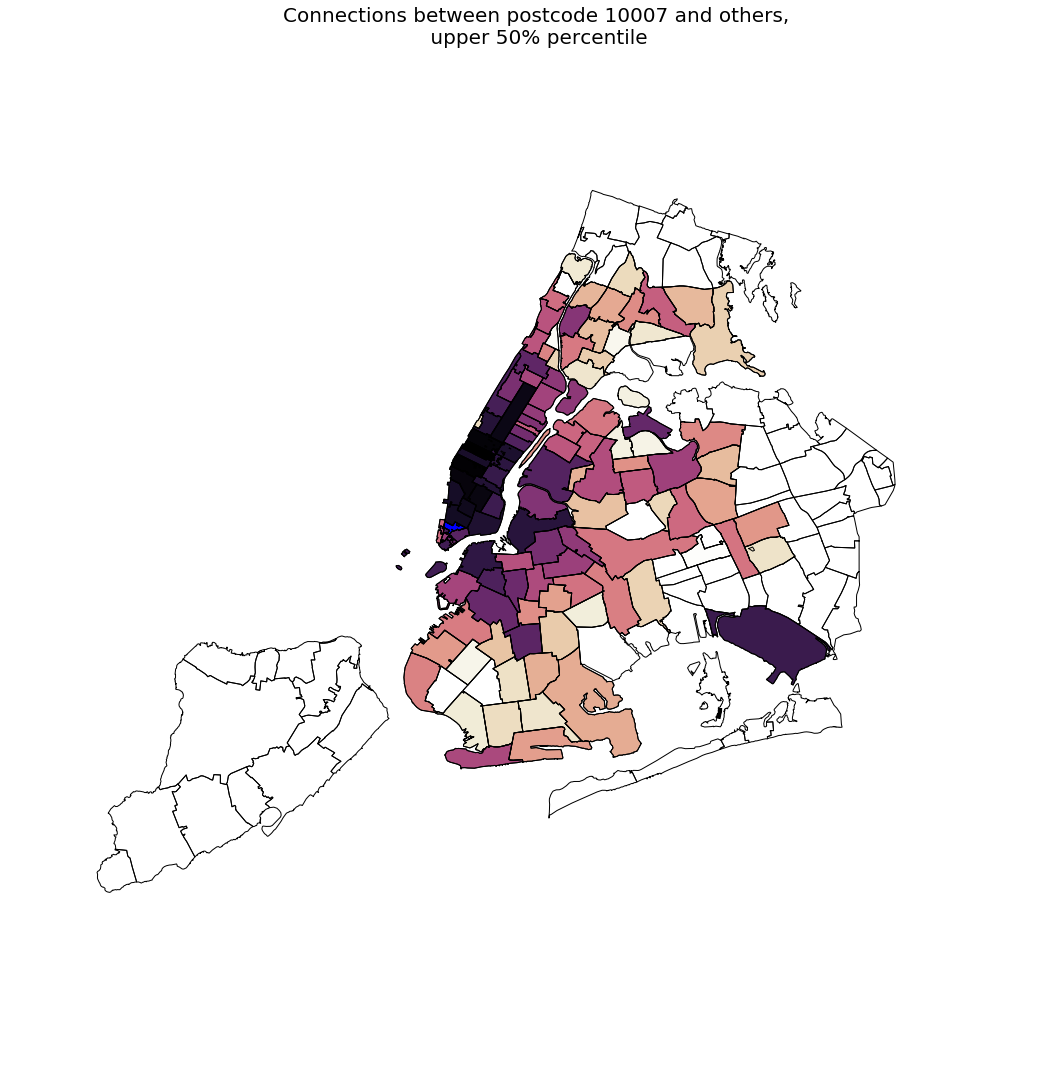

In [25]:
renderConnections(l1, '10007', th=0.5)

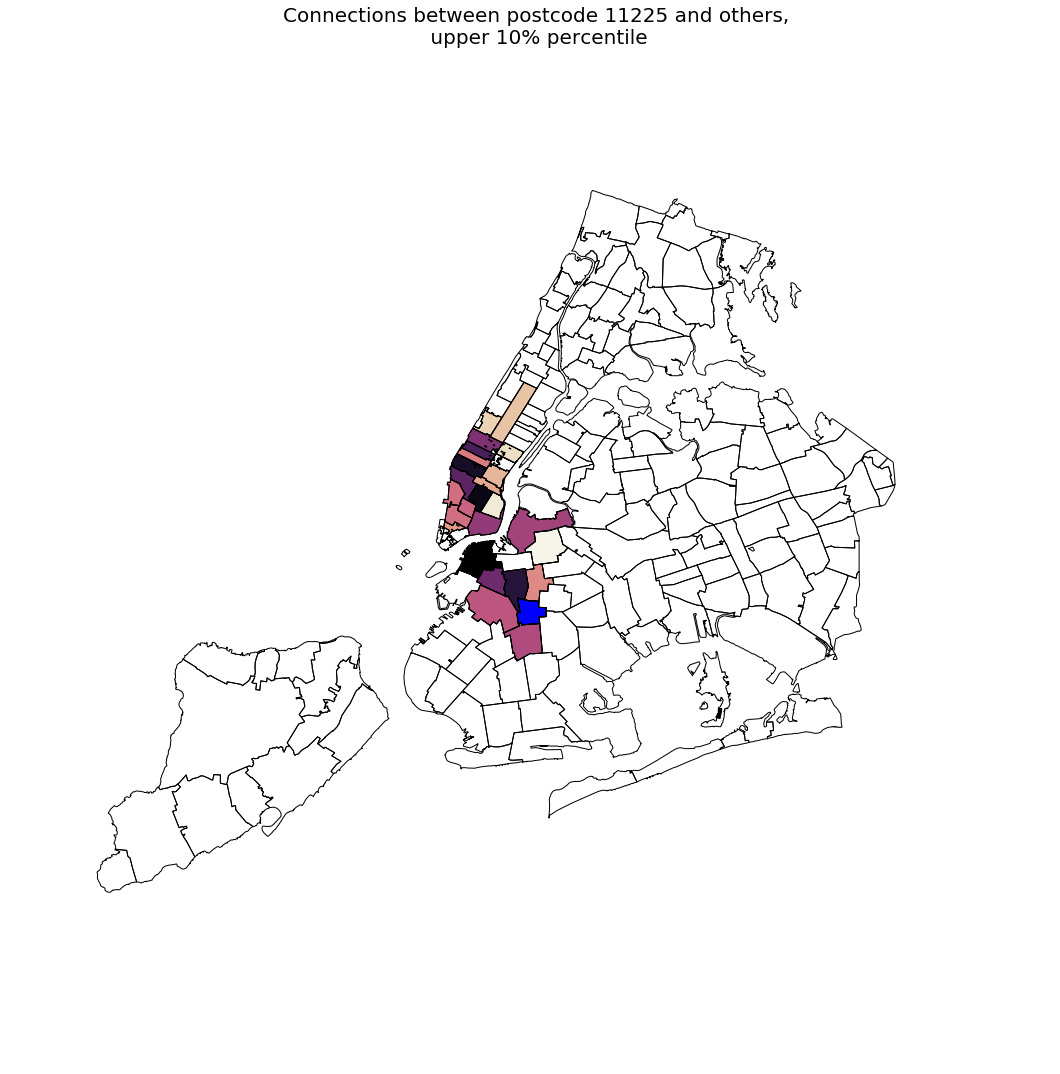

In [26]:
renderConnections(l1, '11225', th=.1)

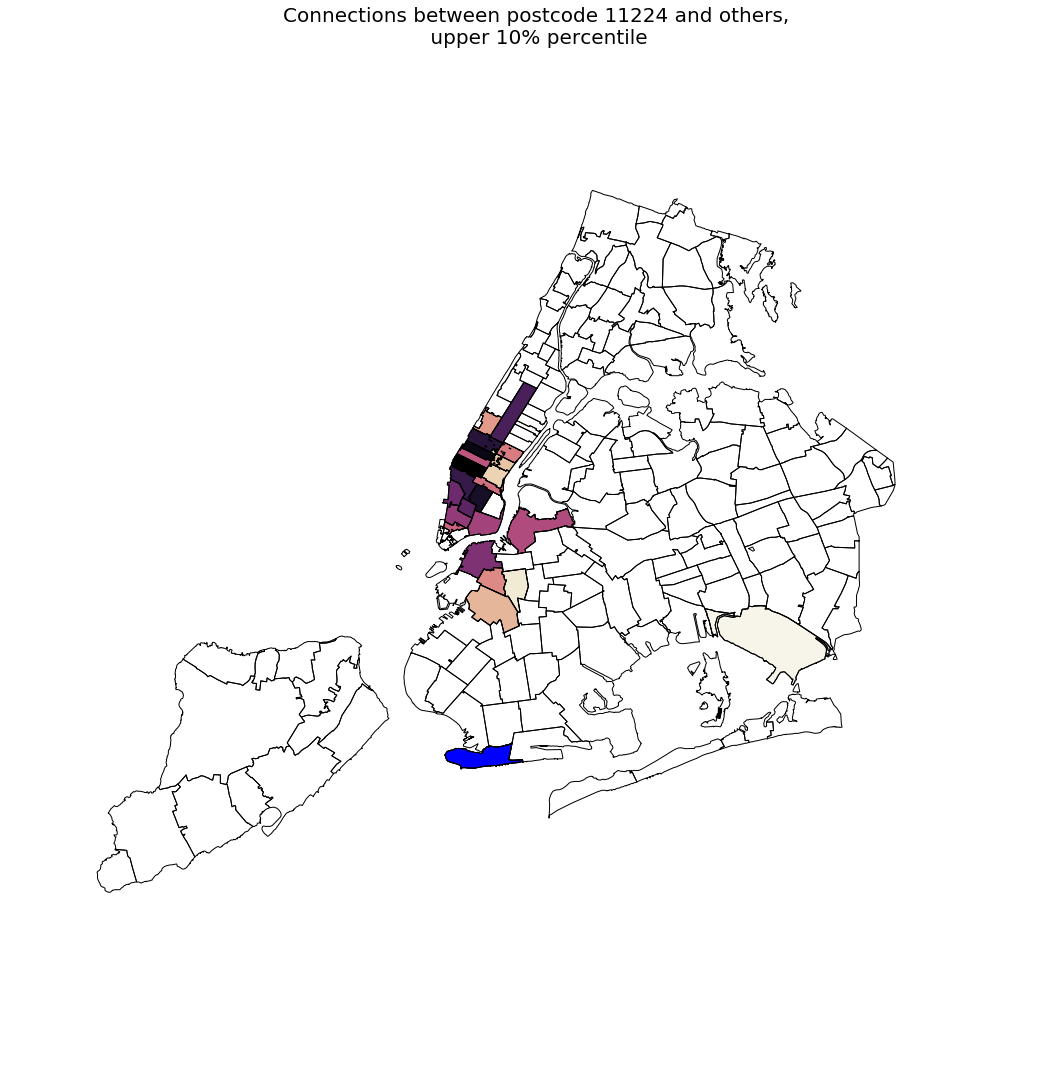

In [27]:
renderConnections(l1, '11224', th=.1)

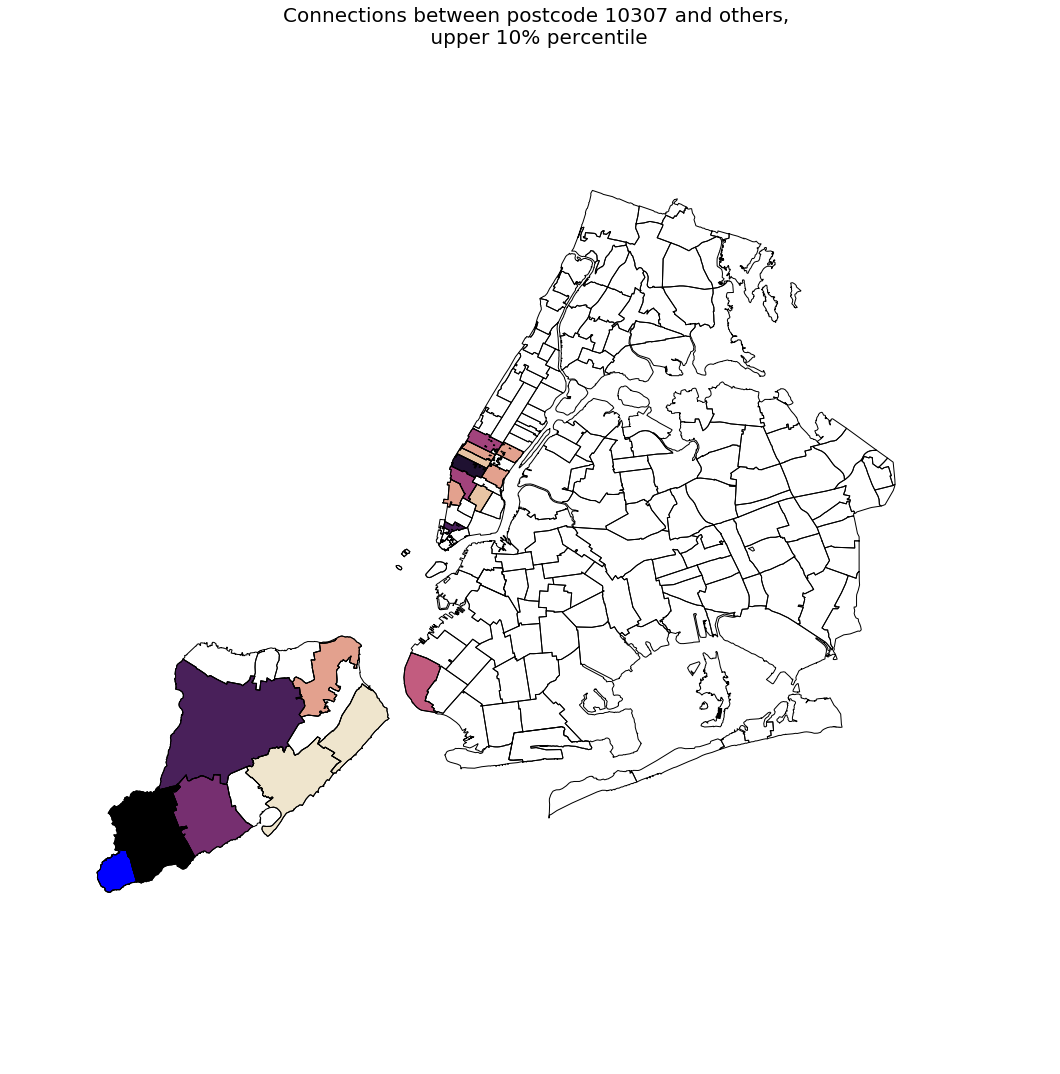

In [28]:
renderConnections(l1, '10307', th=.1)